In [1]:
from astroquery.sdss import SDSS
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from specutils import Spectrum1D
from labellines import labelLines
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import scipy

plt.rcParams['agg.path.chunksize'] = 120

In [11]:
plate = 11397
mjd = 58522
fiber = 534

sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)

spec_hdu = sp[0]
spec_data = spec_hdu[1].data

z = spec_hdu[2].data["z"]

header = spec_hdu[0].header
loglam = spec_data['loglam']
uncert = 1/np.sqrt(spec_data['ivar'])
flux = spec_data['flux']
wavelength = 10**loglam
print(spec_hdu[1].columns)

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)


C:\Users\nihad\AppData\Local\Temp\ipykernel_34460\3044757695.py:14: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:181: UserWarning: Tried to label line Line2D(_child6), but could not find a label for it.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=6564.609999999999, xmax=6564.609999999999, xval=6564.61). Clipping it into the allowed range.
  warnings.warn(


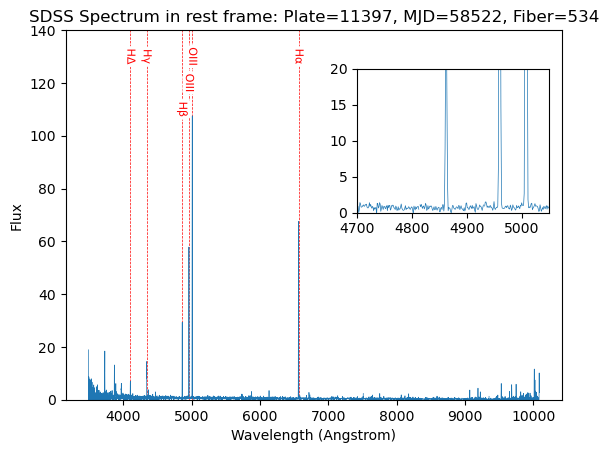

In [13]:
fig, ax = plt.subplots()

#common spectral lines in SDSS
xvals = [6564.61, 5008.240, 4960.295, 4862.68, 4102.89, 4341.68]
label = ['Hα', 'OIII', 'OIII', 'Hβ', 'HΔ', 'Hγ']

for i in range(len(xvals)):
     plt.axvline(xvals[i], color="red", linewidth=0.5, linestyle="--", label= label[i])

#plot the spectrum
ax.plot(wavelength/(1+z), flux, linewidth=0.5)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.ylim(0,140)
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

#vertical lines
offset = [60, 60, 50, 40, 60, 60]
lines = plt.gca().get_lines()
labelLines(lines, align=True, yoffsets=offset, xvals = xvals, fontsize = 8)

#inset plot
inset = fig.add_axes([0.58, 0.5, 0.3, 0.3])
inset.plot(wavelength/(1+z), flux, linewidth=0.5)
inset.set_xlim(4700, 5050)
inset.set_ylim(0, 20)

plt.show()

Text(0.5, 1.0, 'SDSS Spectrum in rest frame: Plate=7572, MJD=56944, Fiber=383')

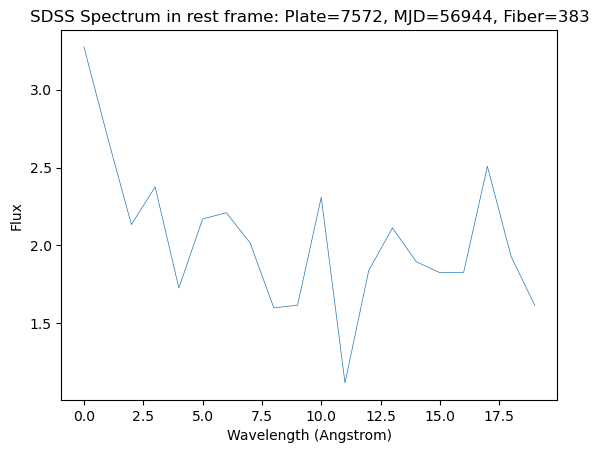

In [7]:
def Gauss(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

[0.34502444 0.3464484  0.3469955  0.34521174 0.39495674 0.38321525
 0.5226784  1.9298259         inf        inf 2.9814003  0.88010156
 0.4366831  0.33623144 0.33570704 0.33681896 0.34308243 0.3635527
 0.35505652 0.3365403 ]
[1.81510986e+02 5.00800852e+03 1.17506214e+00]
[6.21143585e+01 4.96003538e+03 1.20514023e+00] [[ 9.63911965e+00  6.35592689e-03 -6.35485267e-02]
 [ 6.35592689e-03  2.10569229e-03  1.96802898e-04]
 [-6.35485267e-02  1.96802898e-04  1.14115262e-03]]


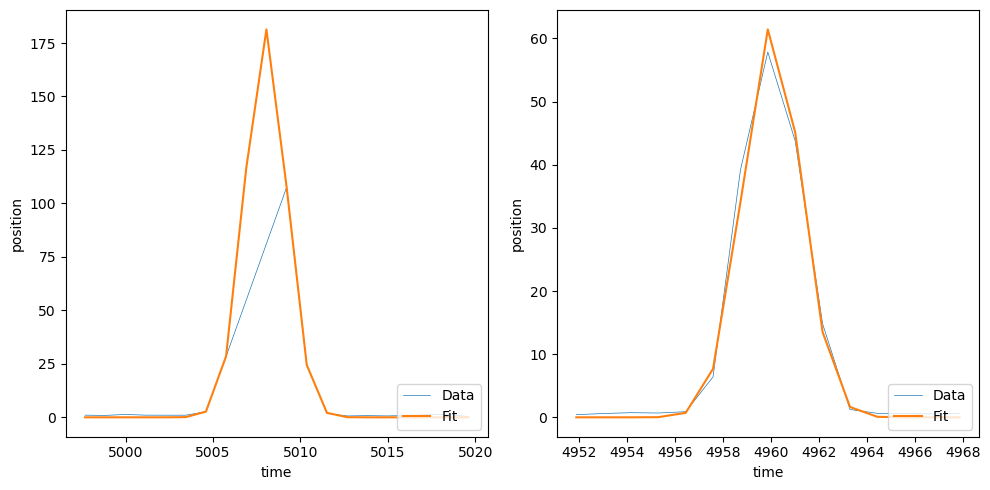

In [15]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
parameters, covariance = curve_fit(Gauss, wavelength[1560:1580]/(1+z), flux[1560:1580], sigma = uncert[1560:1580], method = "lm", p0=[20,5010,4])
print(uncert[1560:1580])
print(parameters)
fit_A, fit_B, fit_C= parameters
fit_y = Gauss(wavelength[1560:1580]/(1+z), fit_A, fit_B, fit_C)

axs[0].plot(wavelength[1560:1580]/(1+z), flux[1560:1580], linewidth=0.5, label='Data')
axs[0].plot(wavelength[1560:1580]/(1+z), fit_y, '-', label='Fit')

parameters, covariance = curve_fit(Gauss, wavelength[1520:1535]/(1+z),flux[1520:1535],  sigma = uncert[1520:1535], method = "lm", p0=[50,4960,4])
print(parameters, covariance)
fit_A, fit_B, fit_C = parameters
fit_y = Gauss(wavelength[1520:1535]/(1+z), fit_A, fit_B, fit_C)

axs[1].plot(wavelength[1520:1535]/(1+z), flux[1520:1535], linewidth=0.5, label='Data')
axs[1].plot(wavelength[1520:1535]/(1+z), fit_y, '-', label='Fit')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='position')
    ax.legend(loc="lower right")

fig.tight_layout()

plt.savefig("Gaussian.png")
plt.show()

In [243]:
def Gauss(x, amp1, amp2, cen, wid1, wid2):
    return (amp1 * np.exp(-(x - cen)**2 / (2 * wid1**2))) + (amp2 * np.exp(-(x - (cen + 47.945))**2 / (2 * wid2**2)))

[6.21251838e+01 1.83627557e+02 4.96004999e+03 1.20691131e+00
 1.17517688e+00]


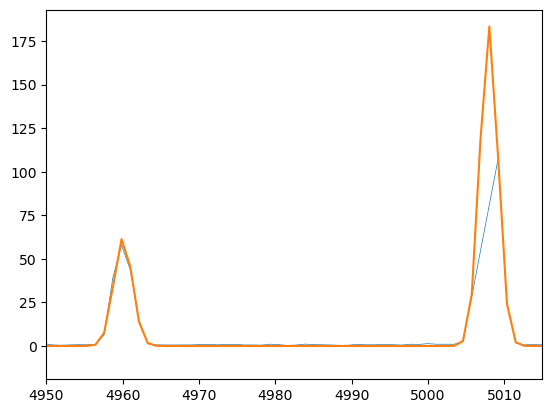

In [245]:
parameters, covariance = curve_fit(Gauss, wavelength/(1+z), flux,sigma = uncert,  method = "lm", p0=[60, 140, 4960, 2, 2])
print(parameters)
fit_A, fit_B, fit_C, fit_D, fit_E= parameters
fit_y = Gauss(wavelength/(1+z), fit_A, fit_B, fit_C, fit_D, fit_E)

plt.plot(wavelength/(1+z), flux, linewidth=0.5, label='Data')
plt.plot(wavelength/(1+z), fit_y, '-', label='Fit')
plt.xlim(4950, 5015)
plt.savefig("Gaussian_fit.png")
plt.show()

In [221]:
plate = 3926
mjd = 55327
fiber = 116

sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)

spec_hdu = sp[0]
spec_data = spec_hdu[1].data

z = spec_hdu[2].data["z"]

header = spec_hdu[0].header
loglam = spec_data['loglam']
flux = spec_data['flux']
wavelength = 10**loglam
print(spec_hdu[1].columns)

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)


[3.00216192e+01 9.26325617e+01 4.96038566e+03 1.21040042e+00
 1.20335313e+00]


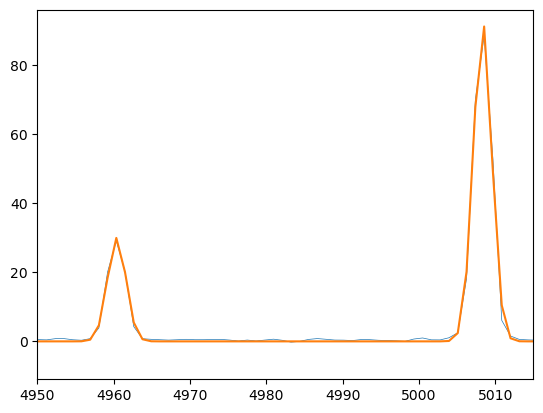

In [223]:
parameters, covariance = curve_fit(Gauss, wavelength/(1+z), flux, method = "lm", p0=[60, 140, 4960, 2, 2])
print(parameters)
fit_A, fit_B, fit_C, fit_D, fit_E= parameters
fit_y = Gauss(wavelength/(1+z), fit_A, fit_B, fit_C, fit_D, fit_E)

plt.plot(wavelength/(1+z), flux, linewidth=0.5, label='Data')
plt.plot(wavelength/(1+z), fit_y, '-', label='Fit')
plt.xlim(4950, 5015)
plt.savefig("Gaussian_fit_noclip.png")
plt.show()